In [1]:
import pandas as pd
import numpy as np

import os

file = pd.read_csv("Ta_thickness_kwh.csv")
file.head()
file["deprate"] = file["thickness"]/file["deptime"]
def Target_Life_(kwh):
    if kwh < 0:
        return 0
    elif 0 < kwh < 200:
        return "BBOL"
    elif 0 < kwh <= 650:
        return "BOL"
    elif 650 < kwh < 1200:
        return "MOL"
    else:
        return "EOL"

file["Target_Life"] = file["kwh"].apply(Target_Life_)
file["Target_Life"].value_counts()
file.columns.values

array(['kwh', 'thickness', 'deptime', 'deprate', 'Target_Life'],
      dtype=object)

In [2]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

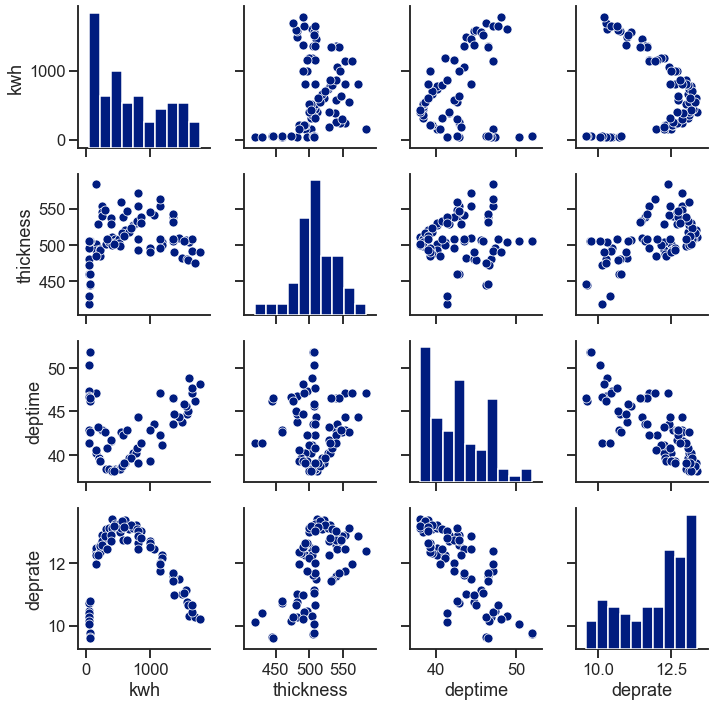

In [3]:
# axE = plt.axes()
sns.pairplot(file)

In [4]:
from sklearn.model_selection import train_test_split
# identify the target column
y_col = 'deptime'

# Split the data into train and test sets
feature_cols = [x for x in file.columns if x not in [y_col, "Target_Life", "deprate"]]
X_data = file[feature_cols]
y_data = file[y_col]

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, 
                                                    test_size=0.3, random_state=7)
X_data.head(2)

,kwh,thickness
0,152.0,583.0
1,153.0,502.0


In [5]:
# import libraries for model and scaling
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, MinMaxScaler, MaxAbsScaler

LR = LinearRegression()

scalers = {'standard': StandardScaler(),
           'minmax': MinMaxScaler(),
           'maxabs': MaxAbsScaler()}



In [6]:
# generate error values for the scaled data in model

mask = X_train.dtypes == np.float
float_columns = X_train.columns[mask]

errors = {}
for scaler_label, scaler in scalers.items():
    trainingset = X_train.copy()  # copy because we dont want to scale this more than once.
    testset = X_test.copy()
    trainingset[float_columns] = scaler.fit_transform(trainingset[float_columns])
    testset[float_columns] = scaler.transform(testset[float_columns])
    LR.fit(trainingset, y_train)
    y_predicted_LR_scaled_skew = LR.predict(testset)
    key = scaler_label + 'scaling:'
    errors[key] = mean_squared_error(y_test, y_predicted_LR_scaled_skew)

errors = pd.Series(errors)
print(errors.to_string())
trainingset.head()


standardscaling:    11.453482
minmaxscaling:      11.453482
maxabsscaling:      11.453482


,kwh,thickness
50,0.221219,0.921098
21,0.310384,0.958148
33,0.668736,0.857633
75,0.453160,0.871355
37,0.889955,0.825043


In [7]:
scaler_to_use = StandardScaler()
trainingset_to_use = X_train.copy()  # copy because we dont want to scale this more than once.
testset_to_use = X_test.copy()
trainingset_to_use[float_columns] = scaler_to_use.fit_transform(trainingset_to_use[float_columns])
testset_to_use[float_columns] = scaler_to_use.transform(testset_to_use[float_columns])
LR.fit(trainingset_to_use, y_train)
y_predicted_LR_scaled = LR.predict(testset_to_use)

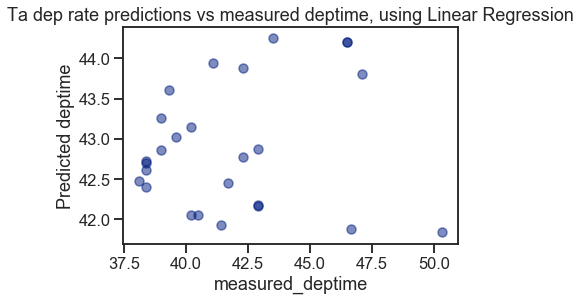

In [8]:
ax = plt.axes()
# we are going to use y_test, y_test_pred
ax.scatter(y_test, y_predicted_LR_scaled, alpha=.5)

ax.set(xlabel='measured_deptime', 
       ylabel='Predicted deptime',
       title='Ta dep rate predictions vs measured deptime, using Linear Regression');

In [8]:
from sklearn.preprocessing import PolynomialFeatures
# Setup the polynomial features
degree = 4
pf = PolynomialFeatures(degree)
X_train_poly = pf.fit_transform(trainingset_to_use)
X_test_poly = pf.transform(testset_to_use)
LR = LR.fit(X_train_poly, y_train)


In [9]:
def rmse(ytrue, ypredicted):
    return np.sqrt(mean_squared_error(ytrue, ypredicted))

In [10]:
linearRegression_rmse = rmse(y_test, LR.predict(X_test_poly))

print(linearRegression_rmse)

4.0638231648854966


In [11]:
from sklearn.linear_model import RidgeCV

alphas = np.array([0.005, 0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 80])

ridgeCV = RidgeCV(alphas=alphas,
                  cv=2).fit(X_train_poly, y_train)

ridgeCV_rmse = rmse(y_test, ridgeCV.predict(X_test_poly))

print(ridgeCV.alpha_, ridgeCV_rmse)

15.0 2.454450899874776


In [12]:
from sklearn.linear_model import LassoCV

alphas2 = np.array([1e-5, 5e-5, 0.0001, 0.0005])

lassoCV = LassoCV(alphas=alphas2,
                  max_iter=5e4,
                  cv=2).fit(X_train_poly, y_train)

lassoCV_rmse = rmse(y_test, lassoCV.predict(X_test_poly))

print(lassoCV.alpha_, lassoCV_rmse) 

0.0005 3.978209665835869


In [13]:
from sklearn.linear_model import ElasticNetCV

l1_ratios = np.linspace(0.1, 0.9, 9)

elasticNetCV = ElasticNetCV(alphas=alphas2, 
                            l1_ratio=l1_ratios,
                            max_iter=1e4).fit(X_train_poly, y_train)
elasticNetCV_rmse = rmse(y_test, elasticNetCV.predict(X_test_poly))

print(elasticNetCV.alpha_, elasticNetCV.l1_ratio_, elasticNetCV_rmse)

C:\Users\odoniku\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\model_selection\_split.py:2053: FutureWarning: You should specify a value for 'cv' instead of relying on the default value. The default value will change from 3 to 5 in version 0.22.
  warnings.warn(CV_WARNING, FutureWarning)


0.0005 0.1 3.9890307608905586


In [14]:
rmse_vals = np.array([linearRegression_rmse, ridgeCV_rmse, lassoCV_rmse, elasticNetCV_rmse])

labels = ['Linear', 'Ridge', 'Lasso', 'ElasticNet']

# rmse_df = pd.DataFrame(rmse_vals.reshape(4,1), index=labels, columns = ['RMSE'])
# # rmse_df.rename(columns={0: 'RMSE'}, inplace=1)
# rmse_df
rmse_df = pd.Series(rmse_vals, index=labels).to_frame()
rmse_df.rename(columns={0: 'RMSE'}, inplace=1)
rmse_df

,RMSE
Linear,4.063823
Ridge,2.454451
Lasso,3.978210
ElasticNet,3.989031


In [15]:
coefficients = pd.DataFrame()
coefficients['linear regression'] = LR.coef_.ravel()
coefficients['ridge regression'] = ridgeCV.coef_.ravel()
coefficients['lasso regression'] = lassoCV.coef_.ravel()
coefficients['elasticNet regression'] = elasticNetCV.coef_.ravel()
# coefficients = coefficients.applymap(abs)
coefficients

,linear regression,ridge regression,lasso regression,elasticNet regression
0,0.000000,0.000000,0.000000,0.000000
1,3.423298,0.652817,3.426420,3.401711
2,1.596179,0.586952,1.605270,1.600907
3,2.062155,0.858268,2.060918,2.062300
4,-2.274703,-0.078879,-2.236775,-2.230711
5,1.711447,0.388776,1.670061,1.678974
6,-3.080919,-0.589725,-3.076316,-3.058826
7,0.635328,0.345487,0.626398,0.627195
8,0.641229,0.237192,0.622868,0.628337
9,-0.276212,0.269819,-0.264839,-0.267794


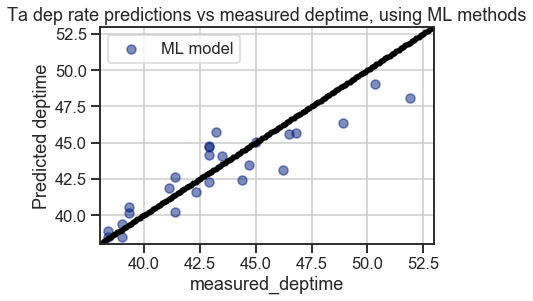

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline


sns.set_context('talk')
sns.set_style('ticks')
sns.set_palette('dark')

ax = plt.axes()
ax.scatter(y_test, LR.predict(X_test_poly), alpha=.5)
# ax.scatter(y_test, ridgeCV.predict(X_test_poly), alpha=.5)
# ax.scatter(y_test, lassoCV.predict(X_test_poly), alpha=.5)
# ax.scatter(y_test, elasticNetCV.predict(X_test_poly), alpha=.5)

ax.set(xlabel='measured_deptime', 
       ylabel='Predicted deptime',
       xlim = [38,53],
       ylim = [38,53],
       title='Ta dep rate predictions vs measured deptime, using ML methods')
x = np.arange(38,53,0.1)
y = x
ax.scatter(x,y, marker='.',color='black')
ax.grid()
plt.legend(['ML model'], loc = 2)

In [17]:
accuracy = {}
modellist = [LR.predict(X_test_poly), ridgeCV.predict(X_test_poly), 
                      lassoCV.predict(X_test_poly), elasticNetCV.predict(X_test_poly)]
modelkey = zip(labels, modellist)
for model, predicted in modelkey:
    accuracy[model] = 1-abs((y_test-predicted)/y_test)
result = pd.DataFrame
result = result(accuracy)
result

,Linear,Ridge,Lasso,ElasticNet
73,0.971769,0.930753,0.971400,0.971171
0,0.593129,0.971082,0.603234,0.601941
58,0.983786,0.961398,0.984096,0.983745
22,0.989942,0.976422,0.989889,0.989852
12,0.958347,0.988060,0.958494,0.958752
70,0.933657,0.936650,0.933556,0.933603
10,0.986758,0.951791,0.986615,0.986390
18,0.997630,0.958398,0.997470,0.997241
4,0.978231,0.953551,0.978120,0.977928
65,0.979980,0.964440,0.980000,0.980031
